In [1]:
import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import dlib

from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential

In [4]:
kdef_dir = 'data/KDEF'
fer_train = 'data/FER-2013/train'
fer_test = 'data/FER-2013/test'

IMG_SIZE = (224, 224)  


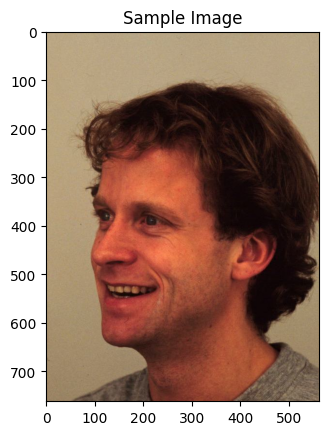

In [5]:
image_path = "data/KDEF/happy/82_8.jpg"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Sample Image")
plt.show()


### Dlib face detection test

In [6]:
detector = dlib.get_frontal_face_detector()
faces = detector(image, 1)
print(f"Number of faces detected: {len(faces)}")

Number of faces detected: 1


In [7]:
import os
import cv2
import dlib
from tqdm import tqdm 

def crop_and_resize_face(image_path, output_size=(224, 224)):
    """
    Detects, crops, and resizes the first detected face in an image using dlib.

    Args:
        image_path (str): Path to the image.
        output_size (tuple): Desired output size (width, height).

    Returns:
        numpy.ndarray: Cropped and resized face or None if no face is detected.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            return None

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        detector = dlib.get_frontal_face_detector()
        faces = detector(rgb_image, 1)

        if len(faces) > 0:
            x1, y1, x2, y2 = faces[0].left(), faces[0].top(), faces[0].right(), faces[0].bottom()

            # Ensure coordinates are within image bounds
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(x2, image.shape[1]), min(y2, image.shape[0])

            cropped_face = image[y1:y2, x1:x2]
            if cropped_face.size == 0:
                print(f"Cropping failed for image: {image_path}")
                return None

            resized_face = cv2.resize(cropped_face, output_size)
            return resized_face
        else:
            print(f"No face detected in {image_path}")
            return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataset_with_dlib(data_dir, target_size=(224, 224)):
    """
    Process all images in the dataset by detecting and cropping faces with dlib.

    Args:
        data_dir (str): Path to the dataset directory.
        target_size (tuple): Desired output size (width, height).

    Returns:
        tuple: Lists of processed images and corresponding labels.
    """
    images = []
    labels = []
    detector = dlib.get_frontal_face_detector()

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            image_path = os.path.join(class_dir, image_name)
            cropped_face = crop_and_resize_face(image_path, target_size)

            if cropped_face is not None:
                images.append(cropped_face)
                labels.append(class_name)

    return images, labels

# Path to KDEF dataset
kdef_dir = "data/KDEF"

# Process KDEF dataset
kdef_images, kdef_labels = process_dataset_with_dlib(kdef_dir)
print(f"Processed {len(kdef_images)} images and {len(kdef_labels)} labels.")


Processing surprise:   2%|▎                     | 7/419 [00:02<01:59,  3.44it/s]

No face detected in data/KDEF/surprise/130_12.jpg


Processing surprise:   9%|█▉                   | 39/419 [00:10<01:43,  3.66it/s]

No face detected in data/KDEF/surprise/101_25.jpg


Processing surprise:  46%|█████████           | 191/419 [00:53<01:02,  3.63it/s]

No face detected in data/KDEF/surprise/53_14.jpg


Processing surprise:  88%|█████████████████▌  | 367/419 [01:43<00:14,  3.55it/s]

No face detected in data/KDEF/surprise/101_14.jpg


Processing neutral:  13%|██▊                   | 53/420 [00:14<01:47,  3.43it/s]

No face detected in data/KDEF/neutral/42_30.jpg


Processing neutral:  61%|████████████▊        | 256/420 [01:11<00:45,  3.63it/s]

No face detected in data/KDEF/neutral/48_13.jpg


Processing disgust:  79%|████████████████▌    | 332/420 [01:34<00:24,  3.60it/s]

No face detected in data/KDEF/disgust/63_33.jpg


Processing disgust:  97%|████████████████████▍| 409/420 [01:56<00:03,  3.64it/s]

No face detected in data/KDEF/disgust/116_32.jpg


Processing disgust: 100%|█████████████████████| 420/420 [01:59<00:00,  3.53it/s]

Processed 2930 images and 2930 labels.


In [16]:
import numpy as np


np.save('kdef_images.npy', np.array(kdef_images))
np.save('kdef_labels.npy', np.array(kdef_labels))

### Quck start

In [17]:
kdef_images = np.load('kdef_images.npy', allow_pickle=True)
kdef_labels = np.load('kdef_labels.npy', allow_pickle=True)

### Resutl of cropping 

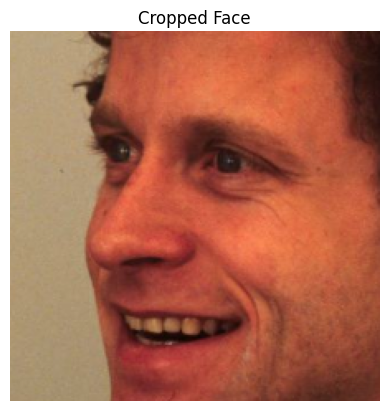

In [11]:
cropped_face = crop_and_resize_face("data/KDEF/happy/82_8.jpg")
if cropped_face is not None:
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Face")
    plt.axis("off")
    plt.show()

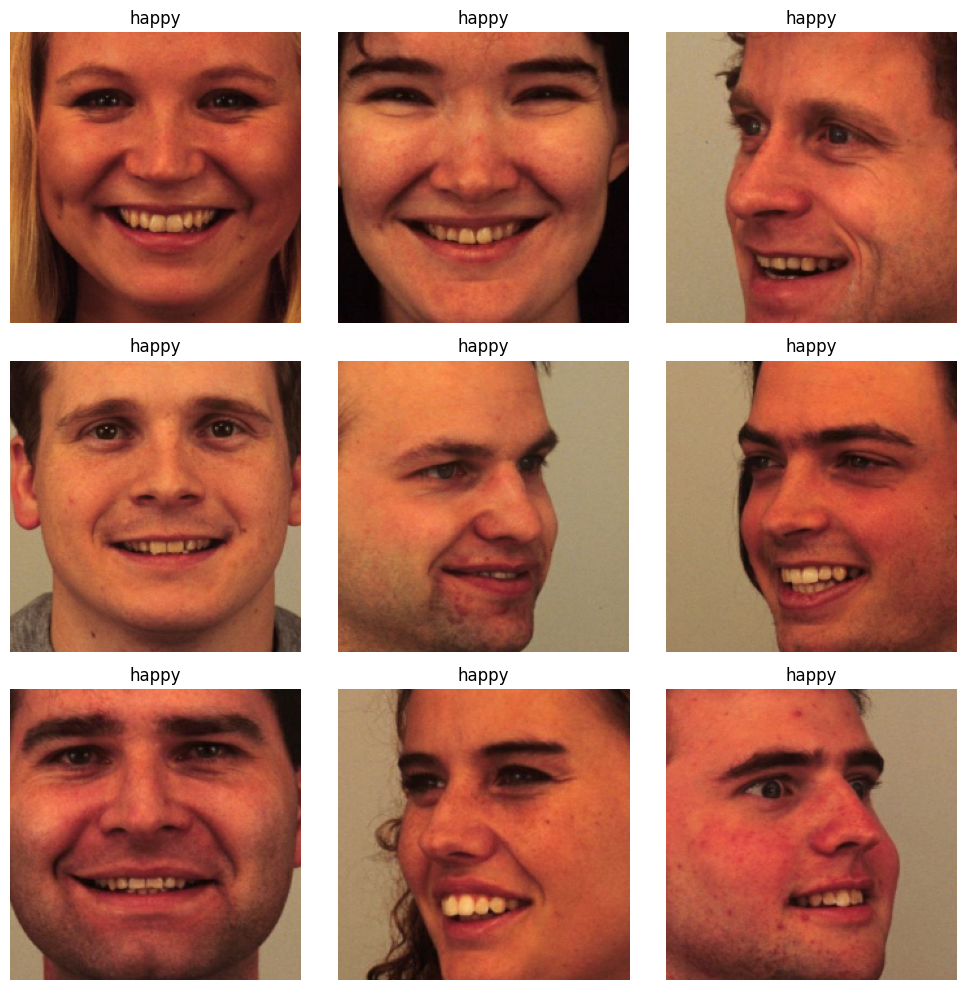

In [20]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, class_names, num_images=9):
    """
    Display a grid of images with their corresponding labels.

    Args:
        images (list or np.array): List of processed images.
        labels (list or np.array): Corresponding labels for the images.
        class_names (list): List of class names.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(10, 10))
    grid_size = int(num_images ** 0.5)  

    for i in range(num_images):
        if i >= len(images):  
            break

        
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(labels[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
show_images_with_labels(kdef_images, kdef_labels, class_names)


###  Convert labels to one-hot encoding

In [21]:
import numpy as np

def convert_labels_to_one_hot(labels, class_names):
    """
    Converts a list of string labels to one-hot encoding.
    
    Args:
        labels (list): List of string labels.
        class_names (list): List of all possible class names.
        
    Returns:
        np.array: One-hot encoded labels.
    """
    class_to_index = {cls: idx for idx, cls in enumerate(class_names)}  # Map class names to indices
    indices = [class_to_index[label] for label in labels]  # Convert labels to indices
    one_hot_labels = np.eye(len(class_names))[indices]  # Convert indices to one-hot encoding
    return one_hot_labels


In [23]:
# one-hot encoding
kdef_labels_one_hot = convert_labels_to_one_hot(kdef_labels, class_names)


print("Original labels:", kdef_labels[700:705])
print("One-hot labels:\n", kdef_labels_one_hot[700:705])


Original labels: ['sad' 'sad' 'sad' 'sad' 'sad']
One-hot labels:
 [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [24]:
print("Original labels:", kdef_labels[0:5])
print("One-hot labels:\n", kdef_labels_one_hot[0:5])

Original labels: ['happy' 'happy' 'happy' 'happy' 'happy']
One-hot labels:
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [25]:
from collections import Counter

Counter(kdef_labels)

Counter({'happy': 420,
         'sad': 419,
         'fear': 420,
         'surprise': 415,
         'neutral': 418,
         'angry': 420,
         'disgust': 418})

In [27]:
np.save('kdef_labels_one_hot.npy',kdef_labels_one_hot)


In [29]:
kdef_labels_one_hot = np.load('kdef_labels_one_hot.npy', allow_pickle=True)

In [115]:
def split_and_create_datasets(images, labels, test_size=0.2, val_size=0.1, batch_size=32, seed=42, augment=False):
    """
    Split data into training, validation, and test sets and create tf.data.Dataset objects.
    
    Optionally adds augmentation to the training dataset.

    Args:
        images (np.array): Array of preprocessed images.
        labels (np.array): One-hot encoded labels.
        test_size (float): Fraction of data to reserve for testing.
        val_size (float): Fraction of remaining data to reserve for validation.
        batch_size (int): Batch size for datasets.
        seed (int): Random seed for reproducibility.
        augment (bool): Whether to add augmentation to training dataset.

    Returns:
        train_dataset, val_dataset, test_dataset: tf.data.Dataset objects.
    """
    # Split into train+val and test
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=seed, stratify=labels.argmax(axis=1)
    )
    
    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train.argmax(axis=1)
    )
    
    # Create tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    if augment:
        # Add augmentation if specified
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomContrast(0.2)
        ])
        train_dataset = train_dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    train_dataset = train_dataset.batch(batch_size).shuffle(len(X_train), seed=seed).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset, test_dataset



In [116]:
train_dataset, val_dataset, test_dataset = split_and_create_datasets(
    images=kdef_images,
    labels=kdef_labels_one_hot,
    batch_size=32,
    augment=True  
)

print(f"Training dataset: {len(train_dataset)} batches")
print(f"Validation dataset: {len(val_dataset)} batches")
print(f"Test dataset: {len(test_dataset)} batches")


Training dataset: 66 batches
Validation dataset: 8 batches
Test dataset: 19 batches


In [96]:
def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)


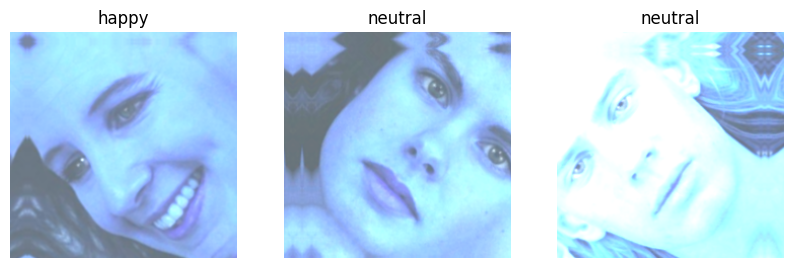

In [117]:
import matplotlib.pyplot as plt


def show_images_with_denormalization(dataset, class_names, num_images=9):
    """
    Display a grid of images with denormalized pixel values.
    Args:
        dataset (tf.data.Dataset): Dataset containing images and labels.
        class_names (list): List of class names.
        num_images (int): Number of images to display.
    """
    dataset_iter = iter(dataset)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        images, labels = next(dataset_iter)
        image = images[i].numpy()
        
        # Denormalize image for visualization
        denormalized_image = (image + [103.939, 116.779, 123.68]).clip(0, 255).astype("uint8")
        label = labels[i].numpy().argmax()
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(denormalized_image)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()



class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
show_images_with_denormalization(train_dataset, class_names, num_images=3)


### Define model architecture

In [90]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


@tf.keras.utils.register_keras_serializable()
def preprocess_input_fn(x):
    return tf.keras.applications.resnet50.preprocess_input(x)

def create_resnet_model(input_shape=(224, 224, 3), num_classes=7):
   
    inputs = layers.Input(shape=input_shape)

    
    x = preprocess_input_fn(inputs)  

   
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base_model.trainable = False  


    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)


    model = models.Model(inputs, outputs)

    return model



### Define Early Stopping and CSV Logger

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tqdm.keras import TqdmCallback


early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    restore_best_weights=True  
)


csv_logger = CSVLogger(
    'training_log.csv',
    append=True
)

### Create and compile resnet model

In [143]:
NUM_CLASSES = 7
BATCH_SIZE = 32
LR = 0.001

model = create_resnet_model(input_shape=IMG_SIZE, num_classes=NUM_CLASSES)
model.compile(
        optimizer=Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

### Model summary

In [144]:
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ input_layer_26[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ input_layer_26[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ input_layer_26[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 7)         │      1,799 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train resnet model

In [145]:
EPOCHS = 50
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[
            early_stopping,
            TqdmCallback(verbose=1),
            csv_logger
        ]
    )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 462ms/step - accuracy: 0.2635 - loss: 2.0946 - val_accuracy: 0.4936 - val_loss: 1.4367
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.4618 - loss: 1.3793 - val_accuracy: 0.5489 - val_loss: 1.2912
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.5070 - loss: 1.2757 - val_accuracy: 0.5447 - val_loss: 1.1982
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.5416 - loss: 1.1918 - val_accuracy: 0.6170 - val_loss: 1.1168
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.5590 - loss: 1.1215 - val_accuracy: 0.5915 - val_loss: 1.0456
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.6107 - loss: 1.0600 - val_accuracy: 0.6255 - val_loss: 0.9931
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6084 - loss: 1.0092 - val_accuracy: 0.5745 - val_loss: 1.0996
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.6220 - loss: 1.0014 - val_accuracy: 0.5

### Test Accuracy

In [146]:

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.6848 - loss: 0.8319
Test Accuracy: 68.26%


### Save model

In [147]:
model.save('models/my_model.keras')

### CSVLogger report

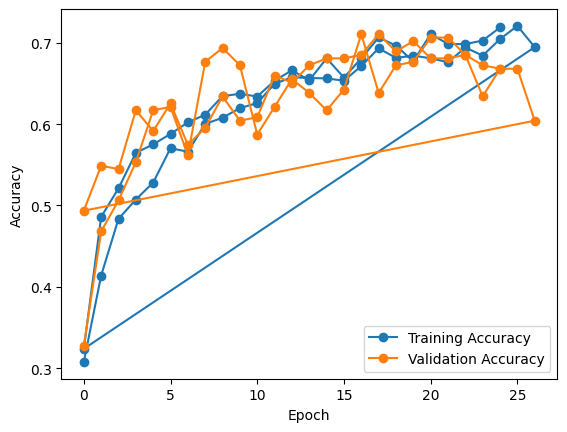

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

log = pd.read_csv('training_log.csv')
plt.plot(log['epoch'], log['accuracy'], label='Training Accuracy', marker='o')
plt.plot(log['epoch'], log['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Report results 

In [124]:
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(generator, model, class_names):
    """
    Generate and plot the confusion matrix for the test dataset.
    Args:
        generator: Test data generator or tf.data.Dataset.
        model: Trained Keras model.
        class_names: List of class names.
    """
    # Get true labels and predictions
    true_labels = []
    predictions = []

    for batch_images, batch_labels in generator:
        batch_predictions = model.predict(batch_images, verbose=0)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        true_labels.extend(np.argmax(batch_labels, axis=1))

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))


2024-11-22 01:45:36.438647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


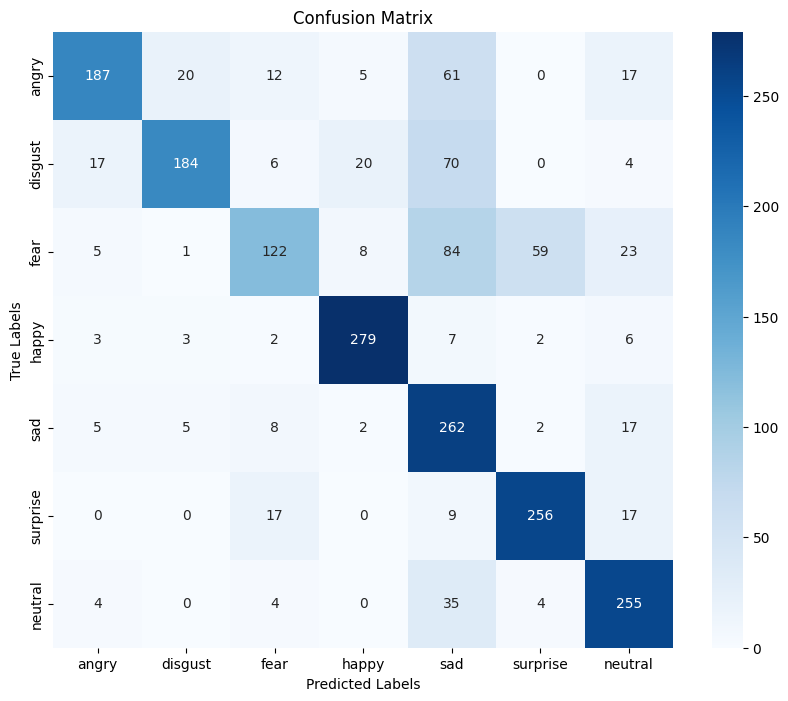


Classification Report:
              precision    recall  f1-score   support

       angry       0.85      0.62      0.72       302
     disgust       0.86      0.61      0.72       301
        fear       0.71      0.40      0.52       302
       happy       0.89      0.92      0.91       302
         sad       0.50      0.87      0.63       301
    surprise       0.79      0.86      0.82       299
     neutral       0.75      0.84      0.80       302

    accuracy                           0.73      2109
   macro avg       0.76      0.73      0.73      2109
weighted avg       0.76      0.73      0.73      2109



In [160]:
plot_confusion_matrix(train_dataset, model, class_names)

### Preprocess FER dataset

In [ ]:
def preprocess_fer_dataset(data_dir, target_size=(224, 224), num_classes=7):
    """
    Preprocess FER dataset by resizing and normalizing images.
    Args:
        data_dir (str): Path to the FER dataset (train or test directory).
        target_size (tuple): Target image size (e.g., 224x224).
        num_classes (int): Total number of emotion classes (including 'disgust').
    Returns:
        np.array: Preprocessed images.
        np.array: One-hot encoded labels.
    """
    images = []
    labels = []
    
    # Loop through class folders, ignoring hidden/system files like .DS_Store
    class_folders = [folder for folder in sorted(os.listdir(data_dir)) if not folder.startswith(".")]
    
    for class_index, class_name in enumerate(class_folders):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                
                # Load image in grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Skipping invalid image: {image_path}")
                    continue  # Skip invalid files
                
                # Resize with high-quality interpolation
                resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)
                
                # Normalize pixel values
                normalized_image = resized_image / 255.0
                
                images.append(normalized_image)
                labels.append(class_index)
    
    # Convert to numpy arrays
    images = np.expand_dims(np.array(images), axis=-1)  # Add channel dimension
    labels = to_categorical(np.array(labels), num_classes=num_classes)
    
    return images, labels

In [ ]:
# Paths to FER directories
fer_train_dir = 'data/FER-2013/train'
fer_test_dir = 'data/FER-2013/test'

# Process train and test datasets
fer_train_images, fer_train_labels = preprocess_fer_dataset(fer_train_dir)
fer_test_images, fer_test_labels = preprocess_fer_dataset(fer_test_dir)

# Save processed datasets for reuse
np.save('fer_train_images.npy', fer_train_images)
np.save('fer_train_labels.npy', fer_train_labels)
np.save('fer_test_images.npy', fer_test_images)
np.save('fer_test_labels.npy', fer_test_labels)

print("FER dataset preprocessing complete.")
print(f"Train images: {fer_train_images.shape}, Train labels: {fer_train_labels.shape}")
print(f"Test images: {fer_test_images.shape}, Test labels: {fer_test_labels.shape}")

### Quick start

In [14]:
import numpy as np

In [33]:
fer_train_images = np.load('fer_train_images.npy', allow_pickle=True)
fer_train_labels = np.load('fer_train_labels.npy', allow_pickle=True)


fer_test_images = np.load('fer_test_images.npy', allow_pickle=True)
fer_test_labels = np.load('fer_test_labels.npy', allow_pickle=True)


In [31]:

print(f"Train images shape: {fer_train_images.shape}")
print(f"Train labels shape: {fer_train_labels.shape}")
print(f"Test images shape: {fer_test_images.shape}")
print(f"Test labels shape: {fer_test_labels.shape}")



Train images shape: (28709, 224, 224, 1)
Train labels shape: (28709, 7)
Test images shape: (7178, 224, 224, 1)
Test labels shape: (7178, 7)
KDFE images shape: (2930, 224, 224, 3)
KDFE labels shape: (2930,)


### Display images 

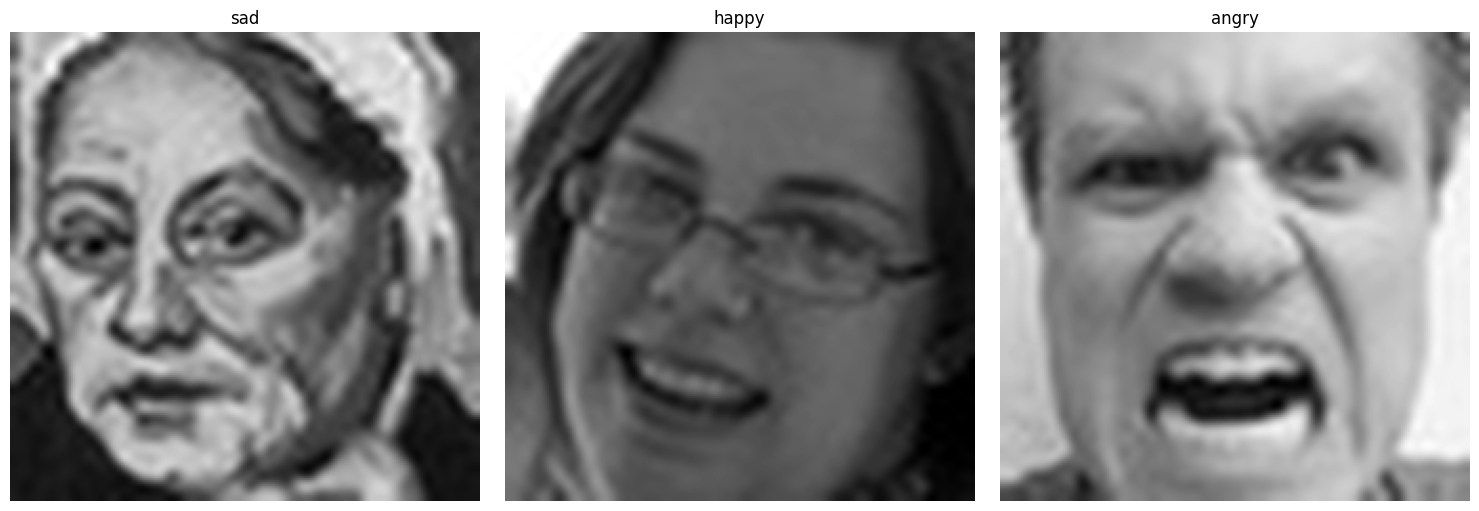

In [42]:
import random

def show_random_images(images, labels, class_names, num_images=3):
    """
    Display a random selection of images from the dataset.

    Args:
        images (np.array): Array of images (height, width, channels).
        labels (np.array): One-hot encoded labels.
        class_names (list): List of class names corresponding to label indices.
        num_images (int): Number of random images to display.
    """
    random_indices = random.sample(range(len(images)), num_images)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image = np.squeeze(images[idx]) 
        label_index = labels[idx].argmax()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(class_names[label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_random_images(fer_train_images, fer_train_labels, class_names)


### Define  merge datasets function

In [182]:
def merge_datasets(images1, labels1, images2, labels2):
    """
    Merge two datasets by concatenating images and labels.
    
    Args:
        images1 (np.array): Images from the first dataset.
        labels1 (np.array): Labels from the first dataset.
        images2 (np.array): Images from the second dataset.
        labels2 (np.array): Labels from the second dataset.
        
    Returns:
        merged_images (np.array): Combined images.
        merged_labels (np.array): Combined labels.
    """
    merged_images = np.concatenate([images1, images2], axis=0)
    merged_labels = np.concatenate([labels1, labels2], axis=0)
    return merged_images, merged_labels

### Merge train and test FER

In [183]:
combined_images, combined_labels = merge_datasets(fer_train_images, fer_train_labels, fer_test_images, fer_test_labels)

print(f"Combined dataset: {combined_images.shape} images, {combined_labels.shape} labels")

Combined dataset: (35887, 224, 224, 1) images, (35887, 7) labels


### Convert to 3 channels image

In [194]:
def convert_to_rgb(images):
    if images.shape[-1] == 1:  
        rgb_images = np.repeat(images, 3, axis=-1)  
        return rgb_images
    return images


In [195]:
fer_dataset = convert_to_rgb(combined_images)

In [196]:
fer_labels = combined_labels

### Shape of combined FER

In [197]:
fer_dataset.shape

(35887, 224, 224, 3)

In [198]:
fer_labels.shape

(35887, 7)

### Show images from datasets

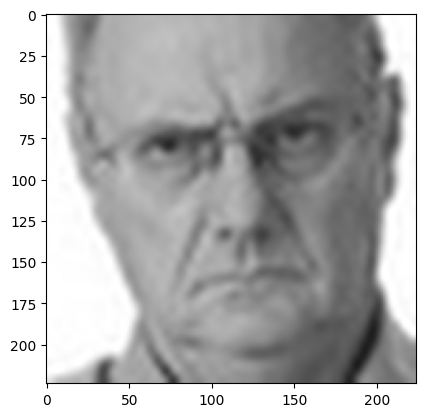

In [202]:
import matplotlib.pyplot as plt

img = fer_dataset[78]  
plt.imshow(img)  
plt.show()



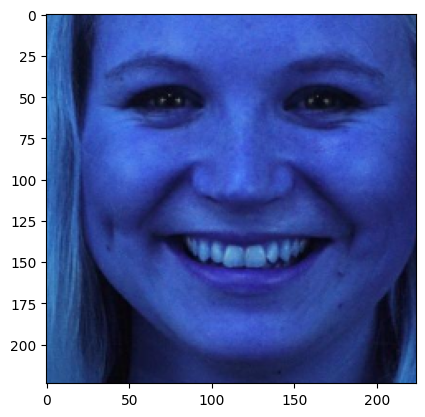

In [201]:
kdef_images
img = kdef_images[0]  
plt.imshow(img)  
plt.show()


### Test haarcascade on FER

Image shape: (224, 224, 3), dtype: uint8, min: 28, max: 255


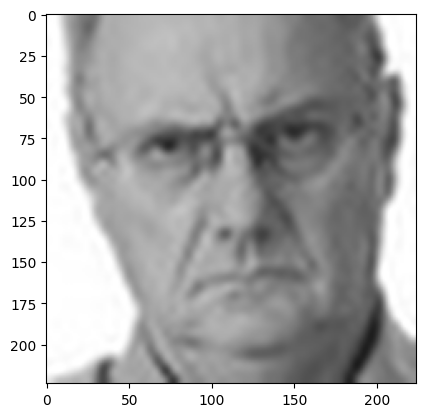

Number of faces detected: 1


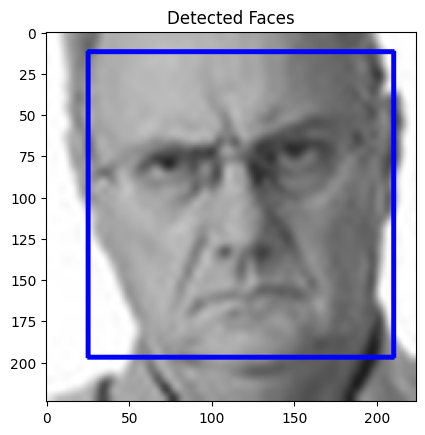

In [214]:

image = fer_dataset[78]

if image.max() <= 1.0: 
    image = (image * 255).astype("uint8")

print(f"Image shape: {image.shape}, dtype: {image.dtype}, min: {image.min()}, max: {image.max()}")

image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.show()

detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = detector.detectMultiScale, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
print(f"Number of faces detected: {len(faces)}")

for (x, y, w, h) in faces:
    cv2.rectangle(image_bgr, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title("Detected Faces")
plt.show()



### Test dlib on FER

In [215]:
detector = dlib.get_frontal_face_detector()
faces = detector(image_bgr, 1)
print(f"Number of faces detected: {len(faces)}")

Number of faces detected: 0


### Crop faces with haar

In [217]:
import cv2
import numpy as np

def detect_faces_with_haar(images, labels, target_size=(224, 224)):
    """
    Detect and crop faces using Haar Cascade in a dataset.
    
    Args:
        images (np.array): Dataset of images (shape: N x H x W x C).
        labels (np.array): One-hot encoded labels for each image.
        target_size (tuple): Target size of cropped faces.

    Returns:
        np.array: Array of cropped face images.
        np.array: Corresponding labels for cropped faces.
        list: List of indices where faces were not detected.
    """
    # Load Haar Cascade
    haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cropped_faces = []
    new_labels = []
    missing_faces = []

    for idx, (image, label) in enumerate(zip(images, labels)):
        # Convert image to uint8
        image_uint8 = (image * 255).astype("uint8") 
        
        # Convert image to grayscale for Haar
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
        
        # Detect faces
        faces = haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            # Use the first detected face (if multiple faces found)
            x, y, w, h = faces[0]
            cropped_face = image_uint8[y:y+h, x:x+w]
            # Resize to target size
            resized_face = cv2.resize(cropped_face, target_size, interpolation=cv2.INTER_LANCZOS4)
            cropped_faces.append(resized_face)
            new_labels.append(label)
        else:
            # Log missing face index
            missing_faces.append(idx)
    
    return np.array(cropped_faces), np.array(new_labels), missing_faces


haar_cropped_faces, haar_cropped_labels, missing_indices = detect_faces_with_haar(fer_dataset, fer_labels)

print(f"Detected faces: {len(haar_cropped_faces)}")
print(f"Labels for detected faces: {len(haar_cropped_labels)}")
print(f"Missing faces: {len(missing_indices)}")


if missing_indices:
    print("Indices of images without detected faces:", missing_indices)


np.save('fer_faces_with_haar_images.npy', haar_cropped_faces)
np.save('fer_faces_with_haar_labels.npy', haar_cropped_labels)
np.save('fer_missing_indices.npy', missing_indices)


Detected faces: 20621
Labels for detected faces: 20621
Missing faces: 15266
Indices of images without detected faces: [2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 19, 24, 25, 28, 30, 33, 36, 38, 39, 40, 44, 46, 47, 48, 50, 54, 55, 58, 59, 62, 63, 65, 67, 70, 71, 72, 74, 82, 83, 84, 86, 87, 91, 92, 93, 94, 97, 98, 100, 102, 103, 105, 106, 109, 115, 116, 117, 119, 121, 122, 123, 126, 127, 129, 132, 133, 142, 143, 149, 150, 153, 154, 155, 156, 157, 159, 161, 162, 163, 164, 166, 167, 172, 173, 174, 177, 182, 185, 187, 189, 194, 197, 198, 200, 201, 203, 204, 205, 206, 209, 210, 212, 213, 215, 217, 219, 222, 225, 226, 227, 234, 235, 237, 239, 246, 249, 250, 251, 252, 254, 255, 257, 262, 268, 269, 270, 271, 275, 281, 284, 286, 287, 290, 291, 296, 297, 300, 302, 303, 304, 307, 308, 310, 311, 314, 315, 317, 319, 320, 321, 325, 326, 331, 332, 333, 335, 336, 340, 342, 344, 345, 346, 350, 351, 352, 353, 354, 355, 359, 361, 362, 363, 364, 365, 369, 374, 377, 381, 382, 384, 387, 389, 393, 395, 396, 397, 39

### Quick start

In [34]:
import numpy as np


haar_faces_images = np.load('fer_faces_with_haar_images.npy', allow_pickle=True)
haar_faces_labels = np.load('fer_faces_with_haar_labels.npy', allow_pickle=True)


kdef_images = np.load('kdef_images.npy', allow_pickle=True)
kdef_labels = np.load('kdef_labels.npy', allow_pickle=True)
kdef_labels_one_hot = np.load('kdef_labels_one_hot.npy', allow_pickle=True)

### Reuslt of cropping faces

In [35]:
print(f"Haar Faces Images shape: {haar_faces_images.shape}")
print(f"Haar Faces Labels shape: {haar_faces_labels.shape}")

print(f"KDFE images shape: {kdef_images.shape}")
print(f"KDFE labels shape: {kdef_labels.shape}")

Haar Faces Images shape: (20621, 224, 224, 3)
Haar Faces Labels shape: (20621, 7)
KDFE images shape: (2930, 224, 224, 3)
KDFE labels shape: (2930,)


### Not detected faces

In [218]:
len(missing_indices)

15266

### Detected faces

In [219]:
len(haar_cropped_faces)

20621

In [220]:
len(haar_cropped_labels)

20621

### Show cropeed face

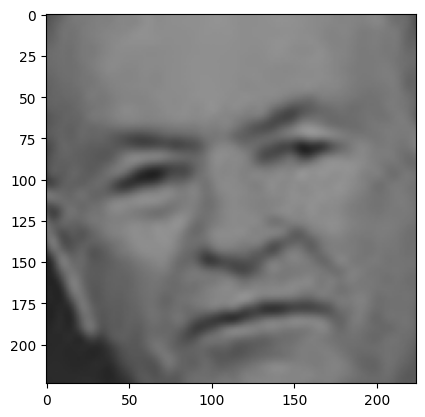

In [223]:
plt.imshow(haar_cropped_faces[78])

### Show images with not detected faces

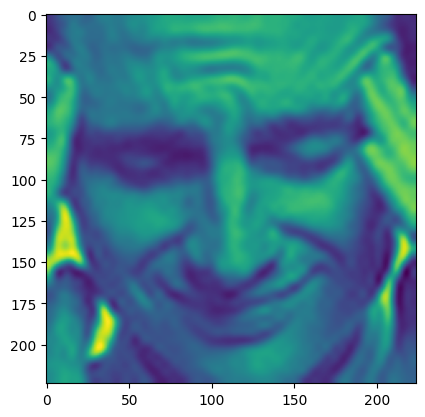

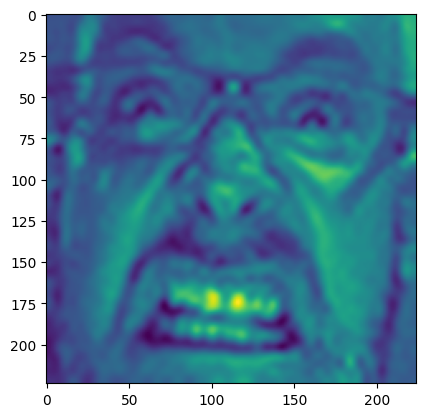

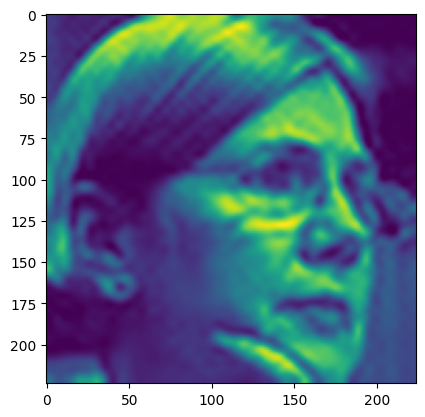

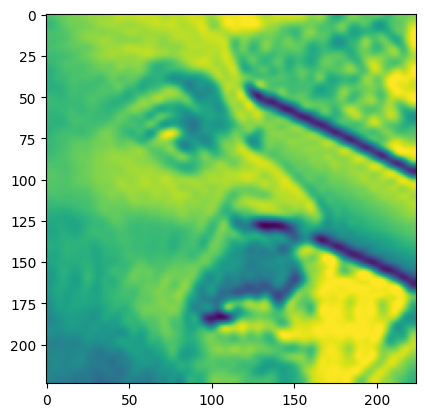

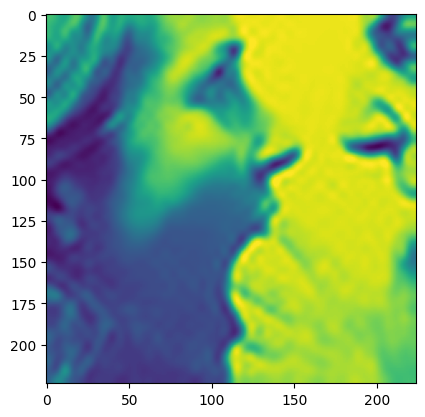

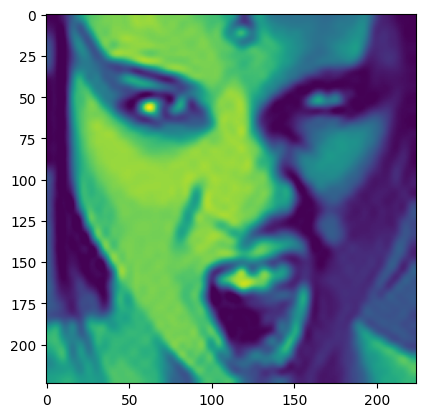

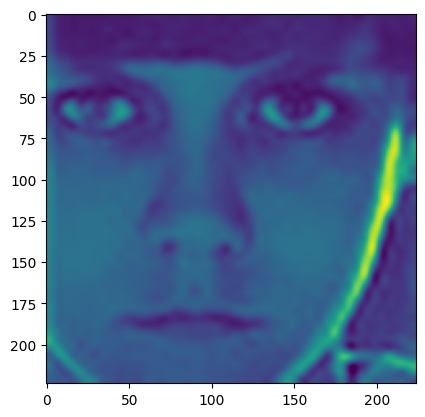

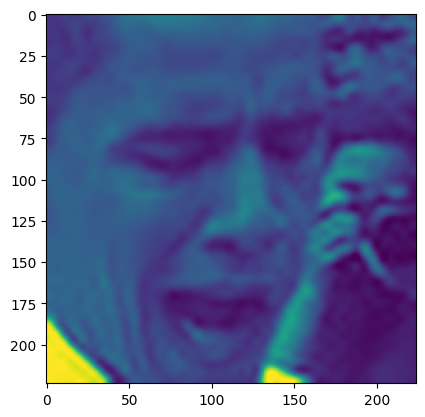

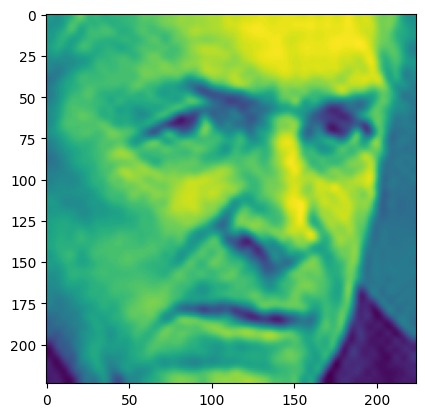

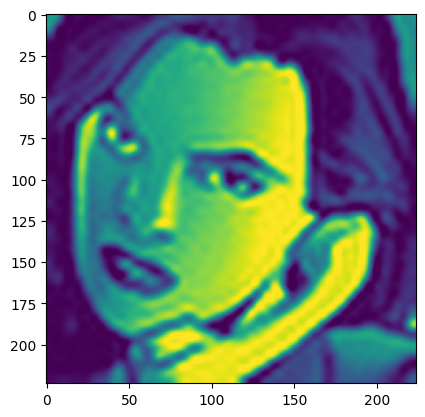

In [228]:
for idx in missing_indices[:10]:
    plt.imshow(combined_images[idx])
    plt.show()


### Merege cropped faces datasets

In [36]:
def combine_datasets(haar_faces, haar_labels, kdef_images, kdef_labels, num_classes=7):
    """
    Combine two datasets into one.
    
    Args:
        haar_faces (np.array): Processed FER images.
        haar_labels (list or np.array): Corresponding labels for FER.
        kdef_images (np.array): Processed KDEF images.
        kdef_labels (list or np.array): Corresponding labels for KDEF.
        num_classes (int): Number of emotion classes.
        
    Returns:
        combined_images, combined_labels: Combined datasets.
    """
    # Ensure labels are NumPy arrays
    haar_labels = np.array(haar_labels)
    kdef_labels = np.array(kdef_labels)
    
    # Ensure labels are in one-hot format
    if len(haar_labels.shape) == 1:  # If labels are integers
        haar_labels = tf.keras.utils.to_categorical(haar_labels, num_classes=num_classes)
    if len(kdef_labels.shape) == 1:  # If labels are integers
        kdef_labels = tf.keras.utils.to_categorical(kdef_labels, num_classes=num_classes)
    
    # Combine images and labels
    combined_images = np.concatenate([haar_faces, kdef_images], axis=0)
    combined_labels = np.concatenate([haar_labels, kdef_labels], axis=0)
    
    return combined_images, combined_labels



### Shape of merged dataset

In [38]:
combined_images, combined_labels = combine_datasets(haar_faces_images, haar_faces_labels, kdef_images, kdef_labels_one_hot)

print(f"Combined dataset: {combined_images.shape} images, {combined_labels.shape} labels")

Combined dataset: (23551, 224, 224, 3) images, (23551, 7) labels


In [12]:
import os
os.chdir('final')

In [39]:
import numpy as np

np.save('combined_images.npy', combined_images)
np.save('combined_labels.npy', combined_labels)

### Start combine dataset

In [13]:

combined_images = np.load('combined_images.npy', allow_pickle=True)
combined_labels = np.load('combined_labels.npy', allow_pickle=True)




print(f"Combined Images shape: {combined_images.shape}")
print(f"Combined Labels shape: {combined_labels.shape}")


Combined Images shape: (23551, 224, 224, 3)
Combined Labels shape: (23551, 7)


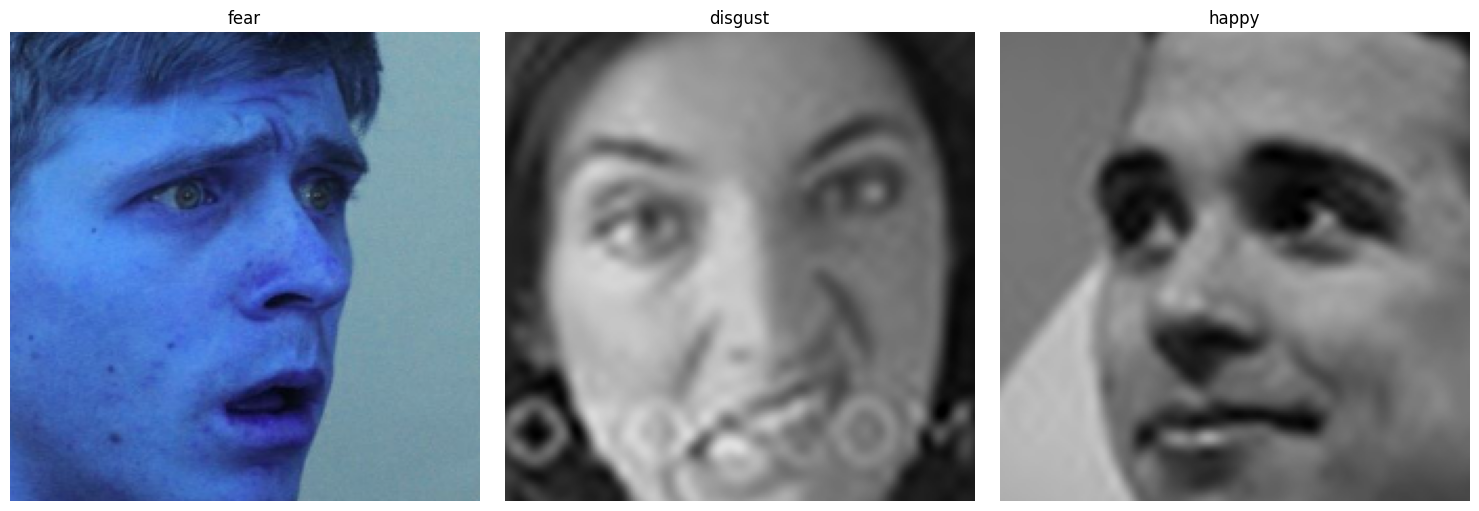

In [46]:
show_random_images(combined_images, combined_labels, class_names)

### Calculate class weights

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight



combined_labels_flat = np.argmax(combined_labels, axis=1)


unique_classes = np.unique(combined_labels_flat)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=combined_labels_flat
)

class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}


### Dislay class distribution

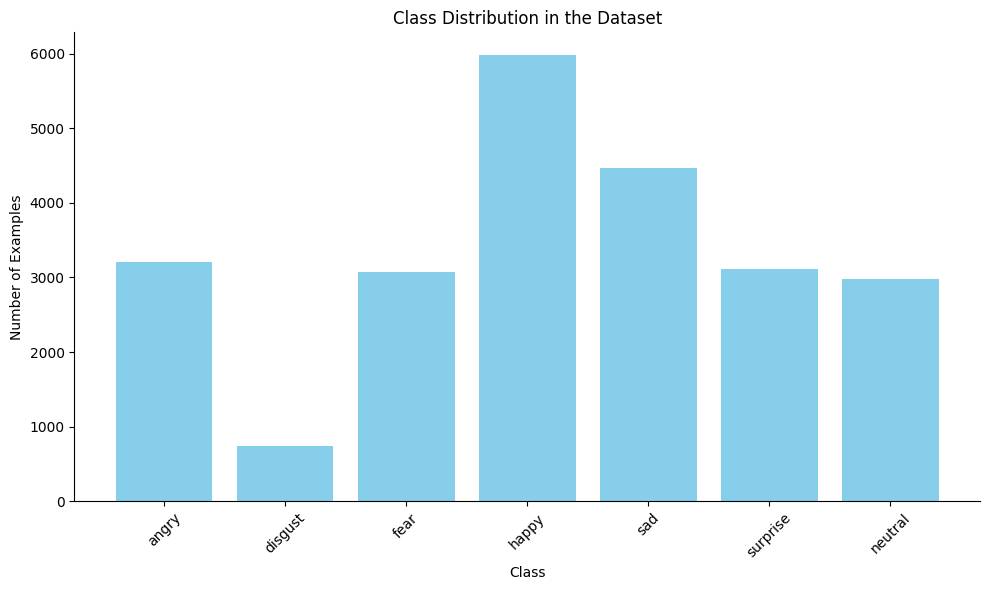

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

combined_labels_flat = np.argmax(combined_labels, axis=1)

class_counts = Counter(combined_labels_flat)

class_counts_values = [class_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_values, color='skyblue')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('class_distribution.png')

plt.show()


### Split dataset into train test val datasets

In [16]:
from sklearn.model_selection import train_test_split

def create_datasets_with_split(images, labels, test_size=0.2, val_size=0.1, batch_size=32, augment=True, seed=42):
    """
    Create train, validation, and test datasets using train_test_split and optional augmentation.

    Args:
        images (np.array): Array of images.
        labels (np.array): Array of one-hot encoded labels.
        test_size (float): Fraction of data for testing.
        val_size (float): Fraction of remaining data for validation.
        batch_size (int): Batch size for tf.data.Dataset.
        augment (bool): Whether to apply augmentation to training dataset.
        seed (int): Random seed for reproducibility.

    Returns:
        train_dataset, val_dataset, test_dataset: tf.data.Dataset objects.
    """
    # Split data into train+val and test
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=seed, stratify=labels.argmax(axis=1)
    )
    
    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train.argmax(axis=1)
    )
    
    # Create training dataset with augmentation
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomContrast(0.2)
        ])
        train_dataset = train_dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Batch and prefetch datasets
    train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=len(X_train), seed=seed).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset, test_dataset

In [17]:

train_dataset, val_dataset, test_dataset = create_datasets_with_split(
    combined_images, combined_labels, test_size=0.2, val_size=0.1, augment=True
)

print(f"Train dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")
print(f"Test dataset batches: {len(test_dataset)}")

Train dataset batches: 530
Validation dataset batches: 59
Test dataset batches: 148


### Show random image from dataset

2024-11-23 04:42:03.155684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-23 04:42:13.162202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 306 of 16956
2024-11-23 04:42:21.175781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


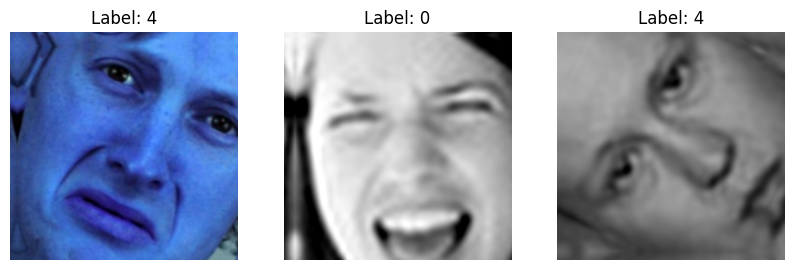

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(dataset, num_images=3):
    """
    Display a few random images from the dataset with their labels.

    Args:
        dataset (tf.data.Dataset): Dataset object to display images from.
        num_images (int): Number of images to display.
    """
    
    images, labels = next(iter(dataset))

    indices = np.random.choice(len(images), num_images, replace=False)
    

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[idx].numpy().astype('uint8'))
        plt.title(f"Label: {np.argmax(labels[idx])}")
        plt.axis('off')
    plt.show()


display_random_images(train_dataset, num_images=3)


### Define model architecture

In [19]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

@tf.keras.utils.register_keras_serializable()
def preprocess_input_fn(x):
    return tf.keras.applications.resnet50.preprocess_input(x)

def create_resnet_model(input_shape=(224, 224, 3), num_classes=7):
   
    inputs = layers.Input(shape=input_shape)

    
    x = preprocess_input_fn(inputs)  
   
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
        layer.trainable = False



    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)


    model = models.Model(inputs, outputs)

    return model


### Create resnet model and compile

In [20]:
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = 7
BATCH_SIZE = 32
LR = 0.001
IMG_SIZE = (224, 224, 3)

model = create_resnet_model(input_shape=IMG_SIZE, num_classes=NUM_CLASSES)
model.compile(
        optimizer=Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

### Train resnet model

In [21]:
EPOCHS = 50
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        class_weight=class_weight_dict,
        callbacks=[
            early_stopping,
            TqdmCallback(verbose=1),
            csv_logger
        ]
    )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50


2024-11-23 04:43:20.765659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 283 of 16956
2024-11-23 04:43:29.658999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 90s 121ms/step - accuracy: 0.2749 - loss: 2.1084 - val_accuracy: 0.4575 - val_loss: 1.5590
Epoch 2/50


2024-11-23 04:44:45.852191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 310 of 16956
2024-11-23 04:44:53.409355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.4146 - loss: 1.5639 - val_accuracy: 0.4751 - val_loss: 1.3937
Epoch 3/50


2024-11-23 04:46:02.084381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 04:46:09.814842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.4789 - loss: 1.4061 - val_accuracy: 0.5600 - val_loss: 1.1796
Epoch 4/50


2024-11-23 04:47:18.462363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 310 of 16956
2024-11-23 04:47:26.179324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.5034 - loss: 1.3096 - val_accuracy: 0.5478 - val_loss: 1.2181
Epoch 5/50


2024-11-23 04:48:34.607180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 320 of 16956
2024-11-23 04:48:41.724974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.5233 - loss: 1.2646 - val_accuracy: 0.5594 - val_loss: 1.2317
Epoch 6/50


2024-11-23 04:49:49.843700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 320 of 16956
2024-11-23 04:49:57.120561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 456s 827ms/step - accuracy: 0.5469 - loss: 1.2031 - val_accuracy: 0.5759 - val_loss: 1.1206
Epoch 7/50


2024-11-23 04:57:25.393286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 316 of 16956
2024-11-23 04:57:32.594453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.5546 - loss: 1.1783 - val_accuracy: 0.5589 - val_loss: 1.2005
Epoch 8/50


2024-11-23 04:58:41.213792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 306 of 16956
2024-11-23 04:58:48.926956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.5681 - loss: 1.1592 - val_accuracy: 0.6051 - val_loss: 1.0721
Epoch 9/50


2024-11-23 04:59:57.521171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 315 of 16956
2024-11-23 05:00:05.104333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 78s 114ms/step - accuracy: 0.5764 - loss: 1.1245 - val_accuracy: 0.5552 - val_loss: 1.1892
Epoch 10/50


2024-11-23 05:01:15.579793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 315 of 16956
2024-11-23 05:01:22.827870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.5852 - loss: 1.0824 - val_accuracy: 0.5918 - val_loss: 1.0870
Epoch 11/50


2024-11-23 05:02:34.817806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 308 of 16956
2024-11-23 05:02:42.465176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 78s 114ms/step - accuracy: 0.6027 - loss: 1.0590 - val_accuracy: 0.6062 - val_loss: 1.0914
Epoch 12/50


2024-11-23 05:03:53.240846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 05:04:00.988027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 78s 114ms/step - accuracy: 0.5933 - loss: 1.0701 - val_accuracy: 0.5993 - val_loss: 1.0846
Epoch 13/50


2024-11-23 05:05:11.602388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 311 of 16956
2024-11-23 05:05:19.147020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 78s 114ms/step - accuracy: 0.6109 - loss: 1.0158 - val_accuracy: 0.6109 - val_loss: 1.0634
Epoch 14/50


2024-11-23 05:06:29.963520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 301 of 16956
2024-11-23 05:06:38.099150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 80s 115ms/step - accuracy: 0.6098 - loss: 1.0144 - val_accuracy: 0.6003 - val_loss: 1.0908
Epoch 15/50


2024-11-23 05:07:49.542165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 289 of 16956
2024-11-23 05:07:58.539400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 117ms/step - accuracy: 0.6244 - loss: 0.9816 - val_accuracy: 0.6258 - val_loss: 1.0271
Epoch 16/50


2024-11-23 05:09:10.838139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 294 of 16956
2024-11-23 05:09:19.153531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.6344 - loss: 0.9605 - val_accuracy: 0.5488 - val_loss: 1.2458
Epoch 17/50


2024-11-23 05:10:31.142082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 05:10:39.125151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 80s 117ms/step - accuracy: 0.6409 - loss: 0.9455 - val_accuracy: 0.6178 - val_loss: 1.0859
Epoch 18/50


2024-11-23 05:11:51.523246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 05:11:59.672287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.6442 - loss: 0.9288 - val_accuracy: 0.6024 - val_loss: 1.0760
Epoch 19/50


2024-11-23 05:13:12.892751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 277 of 16956
2024-11-23 05:13:22.145489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.6496 - loss: 0.9123 - val_accuracy: 0.6332 - val_loss: 1.0152
Epoch 20/50


2024-11-23 05:14:34.865939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 287 of 16956
2024-11-23 05:14:43.147275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.6522 - loss: 0.8988 - val_accuracy: 0.6083 - val_loss: 1.0784
Epoch 21/50


2024-11-23 05:15:54.980174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 303 of 16956
2024-11-23 05:16:03.045681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.6618 - loss: 0.8632 - val_accuracy: 0.6263 - val_loss: 1.0722
Epoch 22/50


2024-11-23 05:17:15.767714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 287 of 16956
2024-11-23 05:17:24.551815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.6663 - loss: 0.8498 - val_accuracy: 0.6200 - val_loss: 1.0585
Epoch 23/50


2024-11-23 05:18:37.577827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 299 of 16956
2024-11-23 05:18:45.727853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 117ms/step - accuracy: 0.6673 - loss: 0.8587 - val_accuracy: 0.5966 - val_loss: 1.1162
Epoch 24/50


2024-11-23 05:19:58.266832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 296 of 16956
2024-11-23 05:20:06.583633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.6864 - loss: 0.8182 - val_accuracy: 0.6354 - val_loss: 1.0365
Epoch 25/50


2024-11-23 05:21:18.675877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 05:21:27.640122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 83s 120ms/step - accuracy: 0.6856 - loss: 0.8299 - val_accuracy: 0.6300 - val_loss: 1.0619
Epoch 26/50


2024-11-23 05:22:41.528789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 290 of 16956
2024-11-23 05:22:50.346046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.6976 - loss: 0.7820 - val_accuracy: 0.6104 - val_loss: 1.0881
Epoch 27/50


2024-11-23 05:24:03.192077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 299 of 16956
2024-11-23 05:24:11.519564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.6930 - loss: 0.7923 - val_accuracy: 0.6258 - val_loss: 1.0974
Epoch 28/50


2024-11-23 05:25:24.504354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 268 of 16956
2024-11-23 05:25:34.090189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.7014 - loss: 0.7741 - val_accuracy: 0.6369 - val_loss: 1.0351
Epoch 29/50


2024-11-23 05:26:46.995844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 266 of 16956
2024-11-23 05:26:56.734343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.7071 - loss: 0.7517 - val_accuracy: 0.6332 - val_loss: 1.0440


In [23]:
model.save('models/res_model.keras')

### Report resnet model training results

2024-11-23 10:25:02.828325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


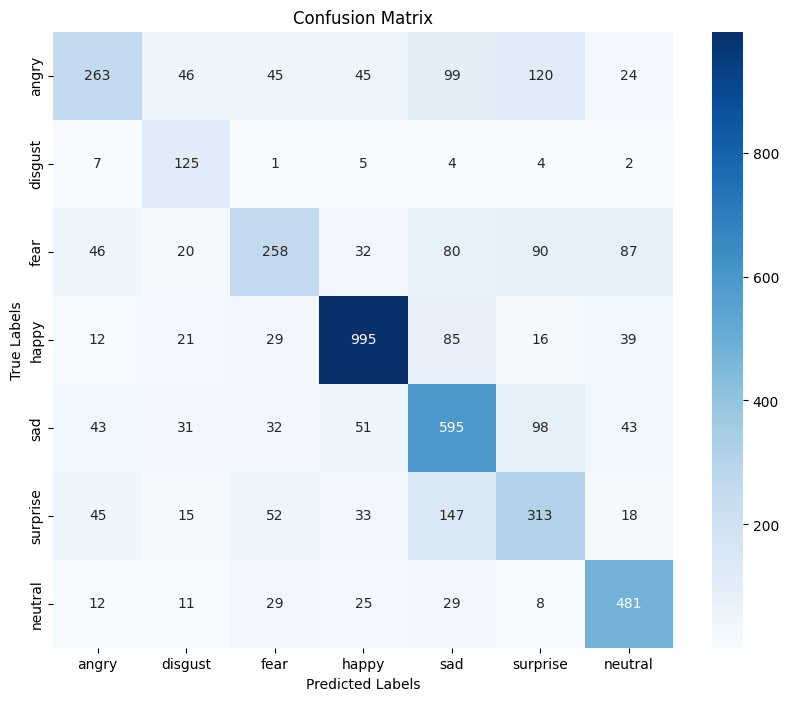


Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.41      0.49       642
     disgust       0.46      0.84      0.60       148
        fear       0.58      0.42      0.49       613
       happy       0.84      0.83      0.84      1197
         sad       0.57      0.67      0.62       893
    surprise       0.48      0.50      0.49       623
     neutral       0.69      0.81      0.75       595

    accuracy                           0.64      4711
   macro avg       0.61      0.64      0.61      4711
weighted avg       0.65      0.64      0.64      4711



In [126]:
plot_confusion_matrix(test_dataset, model, class_names)

### Define architechter for efficientnet and inception

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import efficientnet, inception_v3

@tf.keras.utils.register_keras_serializable()
def preprocess_input_fn_efficientnet(x):
    return efficientnet.preprocess_input(x)

@tf.keras.utils.register_keras_serializable()
def preprocess_input_fn_inception(x):
    return inception_v3.preprocess_input(x)


In [76]:
from tensorflow.keras import layers, models, regularizers

def create_model(model_type="efficientnet", input_shape=(224, 224, 3), num_classes=7):
    
    if model_type == "efficientnet":
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
        preprocess_input_fn = preprocess_input_fn_efficientnet
        
    elif model_type == "inception":
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
        preprocess_input_fn = preprocess_input_fn_inception


    inputs = layers.Input(shape=input_shape)
    x = preprocess_input_fn(inputs) 
    x = base_model(x, training=False)

    base_model.trainable = True
    for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
        layer.trainable = False


    
    x = layers.GlobalAveragePooling2D()(x)

   
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

### Create efficientnet and inception models

In [93]:
eff_model = create_model(model_type="efficientnet")
inc_model = create_model(model_type="inception")

### Compile efficientnet model

In [95]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)



eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="categorical_crossentropy",
     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

### Train efficientnet model

In [96]:
EPOCHS = 50

with tf.device('/GPU:0'):
    history = eff_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        class_weight=class_weight_dict,
        callbacks=[
            #early_stopping,
            TqdmCallback(verbose=1),
            csv_logger
        ]
    )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50


2024-11-23 07:57:24.039218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 239 of 16956
2024-11-23 07:57:34.040991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 529 of 16956
2024-11-23 07:57:34.076271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 100s 125ms/step - accuracy: 0.2019 - loss: 12.9310 - precision_1: 0.2226 - recall_1: 0.1082 - val_accuracy: 0.3163 - val_loss: 11.3618 - val_precision_1: 0.5629 - val_recall_1: 0.1497
Epoch 2/50


2024-11-23 07:58:55.804279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 307 of 16956
2024-11-23 07:59:03.700230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.2868 - loss: 11.4036 - precision_1: 0.3467 - recall_1: 0.1651 - val_accuracy: 0.4225 - val_loss: 10.0532 - val_precision_1: 0.5945 - val_recall_1: 0.2739
Epoch 3/50


2024-11-23 07:59:59.138730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 308 of 16956
2024-11-23 08:00:06.874693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.3303 - loss: 10.0715 - precision_1: 0.4269 - recall_1: 0.2036 - val_accuracy: 0.4607 - val_loss: 8.9163 - val_precision_1: 0.6230 - val_recall_1: 0.3052
Epoch 4/50


2024-11-23 08:01:01.712405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 307 of 16956
2024-11-23 08:01:09.291978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.3673 - loss: 8.9110 - precision_1: 0.4935 - recall_1: 0.2310 - val_accuracy: 0.4793 - val_loss: 7.8888 - val_precision_1: 0.6147 - val_recall_1: 0.3471
Epoch 5/50


2024-11-23 08:02:03.737420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 289 of 16956
2024-11-23 08:02:11.865657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.3930 - loss: 7.8886 - precision_1: 0.5258 - recall_1: 0.2445 - val_accuracy: 0.5085 - val_loss: 6.8965 - val_precision_1: 0.6650 - val_recall_1: 0.3498
Epoch 6/50


2024-11-23 08:03:06.440741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 278 of 16956
2024-11-23 08:03:15.202184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - accuracy: 0.4173 - loss: 6.9546 - precision_1: 0.5683 - recall_1: 0.2605 - val_accuracy: 0.5085 - val_loss: 6.1402 - val_precision_1: 0.6611 - val_recall_1: 0.3572
Epoch 7/50


2024-11-23 08:04:10.184131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 272 of 16956
2024-11-23 08:04:19.160338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - accuracy: 0.4332 - loss: 6.1402 - precision_1: 0.5796 - recall_1: 0.2755 - val_accuracy: 0.5334 - val_loss: 5.3872 - val_precision_1: 0.6794 - val_recall_1: 0.3869
Epoch 8/50


2024-11-23 08:05:14.017781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 298 of 16956
2024-11-23 08:05:22.562548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.4446 - loss: 5.4218 - precision_1: 0.5931 - recall_1: 0.2854 - val_accuracy: 0.5568 - val_loss: 4.7313 - val_precision_1: 0.6873 - val_recall_1: 0.4177
Epoch 9/50


2024-11-23 08:06:17.404703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 08:06:25.387524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.4518 - loss: 4.8426 - precision_1: 0.6196 - recall_1: 0.2916 - val_accuracy: 0.5770 - val_loss: 4.2234 - val_precision_1: 0.7046 - val_recall_1: 0.4432
Epoch 10/50


2024-11-23 08:07:20.775239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 08:07:28.654860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.4723 - loss: 4.2949 - precision_1: 0.6429 - recall_1: 0.3154 - val_accuracy: 0.5823 - val_loss: 3.7390 - val_precision_1: 0.7170 - val_recall_1: 0.4411
Epoch 11/50


2024-11-23 08:08:23.852845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 303 of 16956
2024-11-23 08:08:31.788502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.4715 - loss: 3.8795 - precision_1: 0.6334 - recall_1: 0.3045 - val_accuracy: 0.5701 - val_loss: 3.3667 - val_precision_1: 0.7384 - val_recall_1: 0.4315
Epoch 12/50


2024-11-23 08:09:27.151331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 307 of 16956
2024-11-23 08:09:35.059094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.4800 - loss: 3.5042 - precision_1: 0.6487 - recall_1: 0.3145 - val_accuracy: 0.5791 - val_loss: 3.0600 - val_precision_1: 0.7152 - val_recall_1: 0.4252
Epoch 13/50


2024-11-23 08:10:30.440018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 08:10:38.311332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.5004 - loss: 3.1501 - precision_1: 0.6734 - recall_1: 0.3339 - val_accuracy: 0.5663 - val_loss: 2.8112 - val_precision_1: 0.7168 - val_recall_1: 0.4273
Epoch 14/50


2024-11-23 08:11:33.106401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 08:11:41.006580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.5097 - loss: 2.8565 - precision_1: 0.6917 - recall_1: 0.3433 - val_accuracy: 0.5775 - val_loss: 2.5799 - val_precision_1: 0.7204 - val_recall_1: 0.4363
Epoch 15/50


2024-11-23 08:12:36.366018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 08:12:44.184345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5214 - loss: 2.6309 - precision_1: 0.6967 - recall_1: 0.3533 - val_accuracy: 0.5823 - val_loss: 2.3669 - val_precision_1: 0.7375 - val_recall_1: 0.4475
Epoch 16/50


2024-11-23 08:13:38.689681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 307 of 16956
2024-11-23 08:13:46.603341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.5291 - loss: 2.4518 - precision_1: 0.6922 - recall_1: 0.3578 - val_accuracy: 0.5945 - val_loss: 2.1859 - val_precision_1: 0.7341 - val_recall_1: 0.4660
Epoch 17/50


2024-11-23 08:14:41.810819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 308 of 16956
2024-11-23 08:14:49.509888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5298 - loss: 2.2821 - precision_1: 0.7050 - recall_1: 0.3551 - val_accuracy: 0.5913 - val_loss: 2.0470 - val_precision_1: 0.7256 - val_recall_1: 0.4814
Epoch 18/50


2024-11-23 08:15:44.026369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 309 of 16956
2024-11-23 08:15:51.592938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5419 - loss: 2.1295 - precision_1: 0.7087 - recall_1: 0.3689 - val_accuracy: 0.5881 - val_loss: 1.9486 - val_precision_1: 0.7539 - val_recall_1: 0.4310
Epoch 19/50


2024-11-23 08:16:45.976792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 08:16:53.732330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5335 - loss: 2.0074 - precision_1: 0.7117 - recall_1: 0.3723 - val_accuracy: 0.5833 - val_loss: 1.8523 - val_precision_1: 0.7412 - val_recall_1: 0.4347
Epoch 20/50


2024-11-23 08:17:48.090323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 299 of 16956
2024-11-23 08:17:56.136902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.5571 - loss: 1.8860 - precision_1: 0.7302 - recall_1: 0.3845 - val_accuracy: 0.5913 - val_loss: 1.7914 - val_precision_1: 0.7509 - val_recall_1: 0.4448
Epoch 21/50


2024-11-23 08:18:50.221272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 301 of 16956
2024-11-23 08:18:58.178022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5489 - loss: 1.8080 - precision_1: 0.7228 - recall_1: 0.3837 - val_accuracy: 0.6077 - val_loss: 1.6719 - val_precision_1: 0.7554 - val_recall_1: 0.4607
Epoch 22/50


2024-11-23 08:19:52.268767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 309 of 16956
2024-11-23 08:20:00.151309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.5581 - loss: 1.7288 - precision_1: 0.7417 - recall_1: 0.3941 - val_accuracy: 0.5998 - val_loss: 1.6488 - val_precision_1: 0.7211 - val_recall_1: 0.4666
Epoch 23/50


2024-11-23 08:20:54.849268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 08:21:02.964193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5666 - loss: 1.6658 - precision_1: 0.7357 - recall_1: 0.4012 - val_accuracy: 0.6019 - val_loss: 1.5608 - val_precision_1: 0.7488 - val_recall_1: 0.4809
Epoch 24/50


2024-11-23 08:21:57.234892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 306 of 16956
2024-11-23 08:22:05.103666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.5713 - loss: 1.5879 - precision_1: 0.7423 - recall_1: 0.4053 - val_accuracy: 0.6157 - val_loss: 1.5245 - val_precision_1: 0.7593 - val_recall_1: 0.4538
Epoch 25/50


2024-11-23 08:22:59.095704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 08:23:07.310966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5828 - loss: 1.5436 - precision_1: 0.7477 - recall_1: 0.4132 - val_accuracy: 0.6115 - val_loss: 1.4749 - val_precision_1: 0.7568 - val_recall_1: 0.4756
Epoch 26/50


2024-11-23 08:24:01.277653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 286 of 16956
2024-11-23 08:24:10.239215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 71s 96ms/step - accuracy: 0.5750 - loss: 1.5171 - precision_1: 0.7445 - recall_1: 0.4134 - val_accuracy: 0.6125 - val_loss: 1.4440 - val_precision_1: 0.7630 - val_recall_1: 0.4766
Epoch 27/50


2024-11-23 08:25:12.070174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 08:25:19.914495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5876 - loss: 1.4562 - precision_1: 0.7468 - recall_1: 0.4263 - val_accuracy: 0.6184 - val_loss: 1.3979 - val_precision_1: 0.7658 - val_recall_1: 0.4703
Epoch 28/50


2024-11-23 08:26:14.244687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 301 of 16956
2024-11-23 08:26:22.318305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.5820 - loss: 1.4362 - precision_1: 0.7519 - recall_1: 0.4201 - val_accuracy: 0.6067 - val_loss: 1.4288 - val_precision_1: 0.7540 - val_recall_1: 0.4703
Epoch 29/50


2024-11-23 08:27:16.229753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 287 of 16956
2024-11-23 08:27:24.715487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.5964 - loss: 1.3913 - precision_1: 0.7539 - recall_1: 0.4410 - val_accuracy: 0.6136 - val_loss: 1.4035 - val_precision_1: 0.7628 - val_recall_1: 0.4490
Epoch 30/50


2024-11-23 08:28:18.797893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 298 of 16956
2024-11-23 08:28:26.928529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5816 - loss: 1.3861 - precision_1: 0.7490 - recall_1: 0.4315 - val_accuracy: 0.6263 - val_loss: 1.3364 - val_precision_1: 0.7829 - val_recall_1: 0.4766
Epoch 31/50


2024-11-23 08:29:21.200859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 296 of 16956
2024-11-23 08:29:29.296271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.5891 - loss: 1.3489 - precision_1: 0.7488 - recall_1: 0.4343 - val_accuracy: 0.6205 - val_loss: 1.3226 - val_precision_1: 0.7550 - val_recall_1: 0.5053
Epoch 32/50


2024-11-23 08:30:22.710293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 294 of 16956
2024-11-23 08:30:30.801879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.5956 - loss: 1.3232 - precision_1: 0.7554 - recall_1: 0.4364 - val_accuracy: 0.6067 - val_loss: 1.3552 - val_precision_1: 0.7430 - val_recall_1: 0.4910
Epoch 33/50


2024-11-23 08:31:24.512912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 304 of 16956
2024-11-23 08:31:32.384309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.6096 - loss: 1.3089 - precision_1: 0.7626 - recall_1: 0.4583 - val_accuracy: 0.6168 - val_loss: 1.3304 - val_precision_1: 0.7547 - val_recall_1: 0.4947
Epoch 34/50


2024-11-23 08:32:26.062721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 08:32:33.983163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.6008 - loss: 1.2952 - precision_1: 0.7635 - recall_1: 0.4494 - val_accuracy: 0.6369 - val_loss: 1.2802 - val_precision_1: 0.7757 - val_recall_1: 0.4973
Epoch 35/50


2024-11-23 08:33:27.640229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 303 of 16956
2024-11-23 08:33:35.534218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.6075 - loss: 1.2706 - precision_1: 0.7660 - recall_1: 0.4556 - val_accuracy: 0.6215 - val_loss: 1.2928 - val_precision_1: 0.7577 - val_recall_1: 0.4963
Epoch 36/50


2024-11-23 08:34:29.772102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 305 of 16956
2024-11-23 08:34:37.509390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 324s 579ms/step - accuracy: 0.6150 - loss: 1.2539 - precision_1: 0.7744 - recall_1: 0.4672 - val_accuracy: 0.6226 - val_loss: 1.2786 - val_precision_1: 0.7651 - val_recall_1: 0.4963
Epoch 37/50


2024-11-23 08:39:53.981404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 309 of 16956
2024-11-23 08:40:01.892509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 190s 325ms/step - accuracy: 0.6163 - loss: 1.2444 - precision_1: 0.7575 - recall_1: 0.4562 - val_accuracy: 0.6173 - val_loss: 1.2762 - val_precision_1: 0.7414 - val_recall_1: 0.5143
Epoch 38/50


2024-11-23 08:43:04.329920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 278 of 16956
2024-11-23 08:43:13.203135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - accuracy: 0.6257 - loss: 1.2031 - precision_1: 0.7755 - recall_1: 0.4744 - val_accuracy: 0.6215 - val_loss: 1.2631 - val_precision_1: 0.7635 - val_recall_1: 0.4968
Epoch 39/50


2024-11-23 08:44:08.192778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 08:44:16.168740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.6229 - loss: 1.1945 - precision_1: 0.7771 - recall_1: 0.4764 - val_accuracy: 0.6194 - val_loss: 1.2628 - val_precision_1: 0.7620 - val_recall_1: 0.4963
Epoch 40/50


2024-11-23 08:45:10.302310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 08:45:18.566347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.6210 - loss: 1.1991 - precision_1: 0.7706 - recall_1: 0.4707 - val_accuracy: 0.6178 - val_loss: 1.2869 - val_precision_1: 0.7474 - val_recall_1: 0.4931
Epoch 41/50


2024-11-23 08:46:13.437759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 288 of 16956
2024-11-23 08:46:21.893834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.6225 - loss: 1.2125 - precision_1: 0.7672 - recall_1: 0.4777 - val_accuracy: 0.6274 - val_loss: 1.2405 - val_precision_1: 0.7623 - val_recall_1: 0.5345
Epoch 42/50


2024-11-23 08:47:16.243845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 285 of 16956
2024-11-23 08:47:24.844408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.6271 - loss: 1.1918 - precision_1: 0.7675 - recall_1: 0.4843 - val_accuracy: 0.6359 - val_loss: 1.2455 - val_precision_1: 0.7603 - val_recall_1: 0.5085
Epoch 43/50


2024-11-23 08:48:18.960770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 289 of 16956
2024-11-23 08:48:27.537255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.6311 - loss: 1.1663 - precision_1: 0.7762 - recall_1: 0.4876 - val_accuracy: 0.6285 - val_loss: 1.2381 - val_precision_1: 0.7747 - val_recall_1: 0.4947
Epoch 44/50


2024-11-23 08:49:21.138783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 300 of 16956
2024-11-23 08:49:29.198135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.6314 - loss: 1.1656 - precision_1: 0.7745 - recall_1: 0.4857 - val_accuracy: 0.6316 - val_loss: 1.2541 - val_precision_1: 0.7512 - val_recall_1: 0.5159
Epoch 45/50


2024-11-23 08:50:24.017130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 08:50:32.221748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.6350 - loss: 1.1538 - precision_1: 0.7756 - recall_1: 0.4899 - val_accuracy: 0.6391 - val_loss: 1.2263 - val_precision_1: 0.7608 - val_recall_1: 0.5249
Epoch 46/50


2024-11-23 08:51:27.287358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 295 of 16956
2024-11-23 08:51:35.705736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.6365 - loss: 1.1481 - precision_1: 0.7730 - recall_1: 0.4962 - val_accuracy: 0.6385 - val_loss: 1.2193 - val_precision_1: 0.7726 - val_recall_1: 0.5175
Epoch 47/50


2024-11-23 08:52:30.594738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 08:52:38.902879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 157s 261ms/step - accuracy: 0.6380 - loss: 1.1445 - precision_1: 0.7800 - recall_1: 0.4942 - val_accuracy: 0.6375 - val_loss: 1.2336 - val_precision_1: 0.7602 - val_recall_1: 0.5165
Epoch 48/50


2024-11-23 08:55:07.262873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 226 of 16956
2024-11-23 08:55:26.342476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 1013s 2s/step - accuracy: 0.6343 - loss: 1.1487 - precision_1: 0.7728 - recall_1: 0.4971 - val_accuracy: 0.6470 - val_loss: 1.1876 - val_precision_1: 0.7753 - val_recall_1: 0.5202
Epoch 49/50


2024-11-23 09:19:11.913339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 291 of 16956
2024-11-23 09:19:21.663303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 497s 84ms/step - accuracy: 0.6416 - loss: 1.1264 - precision_1: 0.7773 - recall_1: 0.5081 - val_accuracy: 0.6269 - val_loss: 1.2340 - val_precision_1: 0.7404 - val_recall_1: 0.5101
Epoch 50/50


2024-11-23 09:20:16.903219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 275 of 16956
2024-11-23 09:20:26.371013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - accuracy: 0.6406 - loss: 1.1217 - precision_1: 0.7793 - recall_1: 0.5045 - val_accuracy: 0.6295 - val_loss: 1.2177 - val_precision_1: 0.7537 - val_recall_1: 0.5085


In [104]:
test_accuracy = eff_model.evaluate(test_dataset)



148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6356 - loss: 1.1782 - precision_1: 0.7516 - recall_1: 0.5120


### Report results for efficientnet model

2024-11-23 10:27:17.554088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


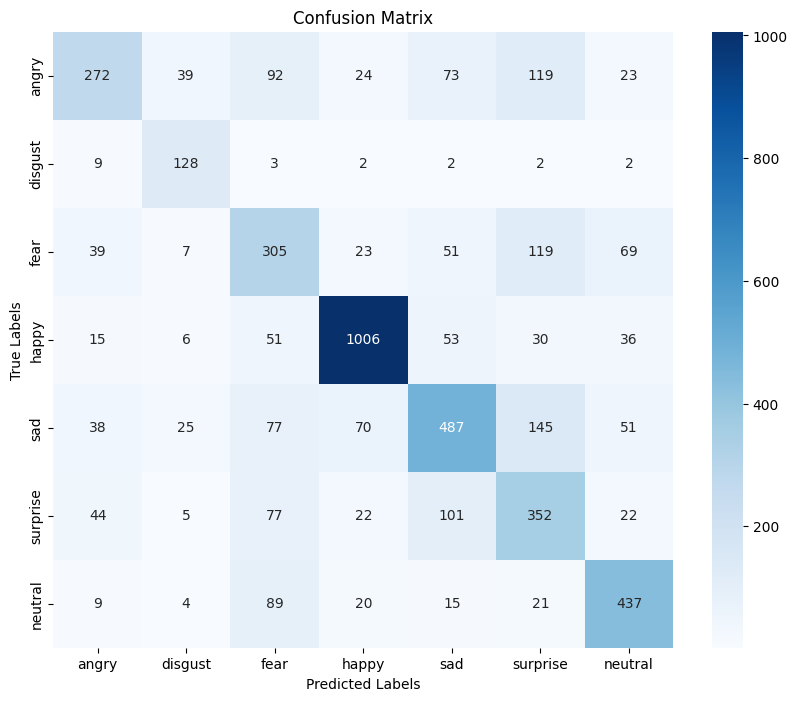


Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.42      0.51       642
     disgust       0.60      0.86      0.71       148
        fear       0.44      0.50      0.47       613
       happy       0.86      0.84      0.85      1197
         sad       0.62      0.55      0.58       893
    surprise       0.45      0.57      0.50       623
     neutral       0.68      0.73      0.71       595

    accuracy                           0.63      4711
   macro avg       0.61      0.64      0.62      4711
weighted avg       0.65      0.63      0.63      4711



In [127]:
plot_confusion_matrix(test_dataset, eff_model, class_names)

### Compoile inception model

In [115]:
inc_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Train inception model

In [121]:
EPOCHS = 50
with tf.device('/GPU:0'):
    history = inc_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        class_weight=class_weight_dict,
        callbacks=[
            early_stopping,
            TqdmCallback(verbose=2),
            csv_logger
        ]
    )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 1/50


2024-11-23 10:00:58.543898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 285 of 16956
2024-11-23 10:01:07.711450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.2836 - loss: 9.1487 - val_accuracy: 0.3689 - val_loss: 7.5870


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 2/50


2024-11-23 10:01:57.554891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 295 of 16956
2024-11-23 10:02:06.054889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.2893 - loss: 7.5575 - val_accuracy: 0.3641 - val_loss: 6.5804


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 3/50


2024-11-23 10:02:56.035238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 10:03:04.358613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.2993 - loss: 6.5543 - val_accuracy: 0.4061 - val_loss: 5.7164


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 4/50


2024-11-23 10:03:54.008928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 291 of 16956
2024-11-23 10:04:02.671390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.3128 - loss: 5.7709 - val_accuracy: 0.4199 - val_loss: 5.0820


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 5/50


2024-11-23 10:04:52.982123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 303 of 16956
2024-11-23 10:05:01.099796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.3201 - loss: 5.1378 - val_accuracy: 0.4257 - val_loss: 4.5510


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 6/50


2024-11-23 10:05:50.801835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 291 of 16956
2024-11-23 10:05:59.399362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.3251 - loss: 4.6260 - val_accuracy: 0.4066 - val_loss: 4.1436


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 7/50


2024-11-23 10:06:49.314736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 10:06:57.842120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.3294 - loss: 4.2322 - val_accuracy: 0.4029 - val_loss: 3.7753


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 8/50


2024-11-23 10:07:47.714479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 302 of 16956
2024-11-23 10:07:55.834112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.3284 - loss: 3.8620 - val_accuracy: 0.4262 - val_loss: 3.4619


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 9/50


2024-11-23 10:08:45.542952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 297 of 16956
2024-11-23 10:08:53.908047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.3482 - loss: 3.5701 - val_accuracy: 0.4406 - val_loss: 3.1785


  0%|          | 0.00/530 [00:00<?, ?batch/s]

Epoch 10/50


2024-11-23 10:09:44.024555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 299 of 16956
2024-11-23 10:09:52.190818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.3468 - loss: 3.2984 - val_accuracy: 0.4289 - val_loss: 3.0151


In [122]:
test_loss, test_accuracy = inc_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.3788 - loss: 7.5721
Test Accuracy: 38.10%


In [ ]:
eff_model.save("eff_model.keras")
inc_model.save("inc_model.keras")